<a href="https://colab.research.google.com/github/mr1er0y/VK_Topic_modeling/blob/main/lab_work.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Подготовка данных

In [1]:
import os
import sys
# import warnings
# if not sys.warnoptions:
#     warnings.simplefilter("ignore")

import numpy as np
import pandas as pd
import sklearn

# Libraries and packages for text (pre-)processing
import string
import re
import nltk


path = "/content/drive/MyDrive/Data_VK/VK_MOSCOW_Posts.csv"

# Чтение данных

In [2]:
df = pd.read_csv(path, sep=';')
df.head()

,ID,URL,CreatedDate,AuthorID,OwnerID,PostType,CommentCount,LikeCount,ShareCount,ViewsCount,Text
0,VK_-197953208_1105,https://vk.com/wall-197953208_1105,2023-02-27T06:46:51Z,VK_-197953208,VK_-197953208,1,0,0,0,0,Состав команды:\n1. Дубовский Иван (lllKORNlll...
1,VK_134219584_2687,https://vk.com/wall134219584_2687,2023-03-04T15:52:56Z,VK_134219584,VK_134219584,1,0,0,1,79,NaN
2,VK_8036_3391,https://vk.com/wall8036_3391,2023-03-07T10:11:00Z,VK_8036,VK_8036,1,0,25,0,637,Сегодня о серьезном. Как отличить правду от фе...
3,VK_8036_3389,https://vk.com/wall8036_3389,2023-03-05T18:44:02Z,VK_8036,VK_8036,1,0,18,0,317,"Классный день, классные люди, классное занятие:)"
4,VK_8036_3387,https://vk.com/wall8036_3387,2023-03-04T14:26:04Z,VK_8036,VK_8036,1,0,22,0,201,NaN


In [3]:
df = df[df["Text"].notna()]
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1366579 entries, 0 to 1447758
Data columns (total 11 columns):
 #   Column        Non-Null Count    Dtype 
---  ------        --------------    ----- 
 0   ID            1366579 non-null  object
 1   URL           1366579 non-null  object
 2   CreatedDate   1366579 non-null  object
 3   AuthorID      1366579 non-null  object
 4   OwnerID       1366579 non-null  object
 5   PostType      1366579 non-null  int64 
 6   CommentCount  1366579 non-null  int64 
 7   LikeCount     1366579 non-null  int64 
 8   ShareCount    1366579 non-null  int64 
 9   ViewsCount    1366579 non-null  int64 
 10  Text          1366579 non-null  object
dtypes: int64(5), object(6)
memory usage: 125.1+ MB


Давайте посмотрим отношение между комметариями и постами

1 - это посты в социальной сети VK

2 - это комментарии к постам



In [4]:
df["PostType"].value_counts().to_frame("num")

,num
2,1136530
1,230049


In [5]:
df = df[df["PostType"] == 1]
df["Text"].to_frame()

,Text
0,Состав команды:\n1. Дубовский Иван (lllKORNlll...
2,Сегодня о серьезном. Как отличить правду от фе...
3,"Классный день, классные люди, классное занятие:)"
5,"Просто будь собой. Легко сказать. Признайтесь,..."
6,Сегодня вся лента пестрит весной. Если бы мони...
...,...
1447753,"Продам Форд Мондео на ходу, автомат поломан ед..."
1447754,"Продам ВАЗ 2110, 2002 года, хорошая комплектац..."
1447756,"Ездить можно по закону, но не переоформить,\nР..."
1447757,ВАЗ 2106 \nЮр чистая\nНе гнилая \nНа ходу \n43...


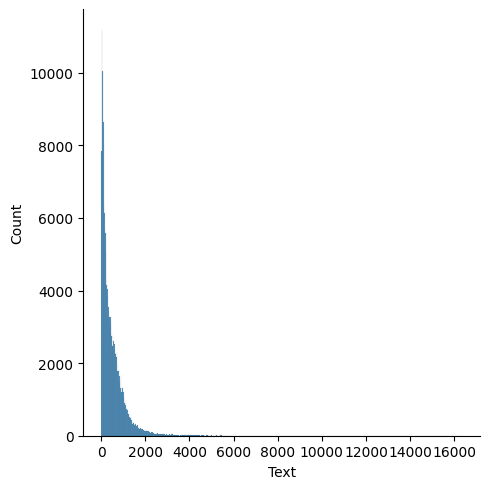

In [6]:
import seaborn as sns
import matplotlib.pyplot as plt
sns.displot(df["Text"].apply(lambda x: len(x)), kde=False)

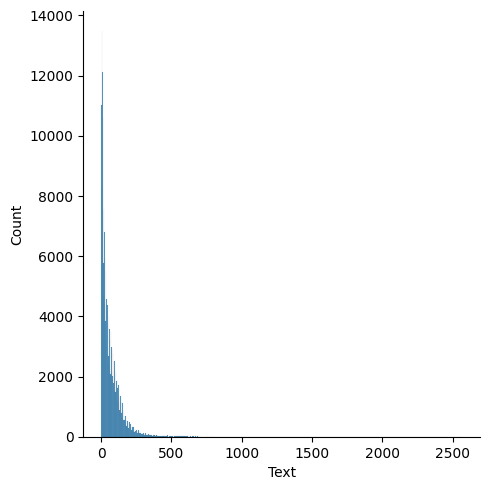

In [7]:
sns.displot(df["Text"].apply(lambda x: len(x.split())), kde=False)

In [8]:
df = df[df["Text"].apply(lambda x: len(x.split())) < 400]
df =  df[df["Text"].apply(lambda x: len(x.split())) > 6]

In [9]:
df = df.sample(2000, random_state=77)

### Поиск сущностей
за основу был взят [код ноутбука](https://www.kaggle.com/code/mohamedsoubhi/feature-engineering-for-nlp-russian-tweets)

[Другие модели](https://spacy.io/models/ru)

In [ ]:
!python -m spacy download ru_core_news_sm

In [11]:
import spacy
from spacy.lang.en.stop_words import STOP_WORDS
# Load the en_core_web_sm model
nlp = spacy.load('ru_core_news_sm')

def nlp_tokens(string):
    # Create a Doc object
    doc = nlp(string)
    # Generate list of tokens
    tokens = [token.text for token in doc]
    return tokens

def nlp_lemmas(string):
    # Create a Doc object
    doc = nlp(string)
    # Generate list of tokens
    lemmas = [token.lemma_ for token in doc]
    a_lemmas = [lemma for lemma in lemmas
                if (lemma.isalpha() or lemma == '-PRON-') and lemma not in STOP_WORDS]
    return a_lemmas

def find_persons(text):
  # Create Doc object
  text = re.sub(r'[\n\t]', '', text)
  doc =  nlp(text)

  # Identify the persons
  persons = dict()
  for ent in doc.ents:
    if ent.label_ not in persons:
       persons[ent.label_] = []
    persons[ent.label_].append(ent.text)

  persons["hashtags"] = re.findall(r'#\w+', text)
  persons["link"] = re.findall(r'https?://\S+', text)
  # Return persons
  return persons

In [12]:
tmp = df['Text'].apply(find_persons)
dt = pd.DataFrame(list(tmp))
dt.head()

,ORG,LOC,PER,hashtags,link
0,[CELINE],[Италия],[Туфли],[],[]
1,NaN,[Норильск],[Леонид Прядко],[],[]
2,"[Высшей школе режиссеров и сценаристов, Высшей...",NaN,"[Валерия Мартынова, ДневникКиношколы]",[#ДневникКиношколы],[]
3,[ОП],"[Воронежской области, Воронеже, Артамонова, Со...","[Вячеслав Бочаров, Ивана Артамонова, Орлом, Ив...",[],[]
4,"[ЖК «, MR Group, ЖК «, Павелецкого вокзала, ЖК...",[Домодедовская],"[Микрорайон, Павлом Железновым, Иваном Поздняк...",[],[https://www.novostroy-m.ru/kompanii/mr_group/...


In [13]:
df = df.reset_index(drop=True)

In [14]:
df = pd.concat([df, dt], axis=1)
df.head()

,ID,URL,CreatedDate,AuthorID,OwnerID,PostType,CommentCount,LikeCount,ShareCount,ViewsCount,Text,ORG,LOC,PER,hashtags,link
0,VK_-58280124_133258,https://vk.com/wall-58280124_133258,2023-03-20T11:29:35Z,VK_-58280124,VK_-58280124,1,0,0,0,557,"Продам туфли лак,бренд CELINE, Италия,родные,н...",[CELINE],[Италия],[Туфли],[],[]
1,VK_-27_41164,https://vk.com/wall-27_41164,2023-03-12T02:11:00Z,VK_-27,VK_-27,1,0,165,8,5393,Норильск с необычного ракурса.\nФото: Леонид П...,NaN,[Норильск],[Леонид Прядко],[],[]
2,VK_-29148589_16516,https://vk.com/wall-29148589_16516,2023-03-20T09:22:07Z,VK_-29148589,VK_-29148589,1,0,12,0,941,Выставка студенческих работ в Высшей школе реж...,"[Высшей школе режиссеров и сценаристов, Высшей...",NaN,"[Валерия Мартынова, ДневникКиношколы]",[#ДневникКиношколы],[]
3,VK_-93005764_45620,https://vk.com/wall-93005764_45620,2023-03-15T09:10:04Z,VK_-93005764,VK_-93005764,1,3,6,0,522,Вячеслав Бочаров призвал власти Воронежской об...,[ОП],"[Воронежской области, Воронеже, Артамонова, Со...","[Вячеслав Бочаров, Ивана Артамонова, Орлом, Ив...",[],[]
4,VK_-139507580_5438,https://vk.com/wall-139507580_5438,2023-03-03T13:30:00Z,VK_-139507580,VK_-139507580,1,0,2,0,145,📌Скидка 15% на весь пул квартир в ЖК «Эко Видн...,"[ЖК «, MR Group, ЖК «, Павелецкого вокзала, ЖК...",[Домодедовская],"[Микрорайон, Павлом Железновым, Иваном Поздняк...",[],[https://www.novostroy-m.ru/kompanii/mr_group/...


# Text Cleaning Tasks

### Capitalization/ Приведение текста к нижнему регистру

In [15]:
df["text_clean"] = df["Text"].apply(lambda x: x.lower())

In [16]:
def remove_e(text):
    """
        Change Ёё  to е from a sample string
    """
    return  re.sub('[Ёё]', 'е',  text)

In [17]:
df["text_clean"] = df["text_clean"].apply(remove_e)

### Удаление URLs

In [18]:
def remove_URL(text):
    """
        Remove URLs from a sample string
    """
    return re.sub(r"https?://\S+|www\.\S+", "", text)

In [19]:
# remove urls from the text
df["text_clean"] = df["text_clean"].apply(lambda x: remove_URL(x))

### Удаление HTML tags

In [20]:
def remove_html(text):
    """
        Remove the html in sample text
    """
    html = re.compile(r"<.*?>|&([a-z0-9]+|#[0-9]{1,6}|#x[0-9a-f]{1,6});")
    return re.sub(html, "", text)

In [21]:
# remove html from the text
df["text_clean"] = df["text_clean"].apply(lambda x: remove_html(x))

In [22]:
df.head(5)

,ID,URL,CreatedDate,AuthorID,OwnerID,PostType,CommentCount,LikeCount,ShareCount,ViewsCount,Text,ORG,LOC,PER,hashtags,link,text_clean
0,VK_-58280124_133258,https://vk.com/wall-58280124_133258,2023-03-20T11:29:35Z,VK_-58280124,VK_-58280124,1,0,0,0,557,"Продам туфли лак,бренд CELINE, Италия,родные,н...",[CELINE],[Италия],[Туфли],[],[],"продам туфли лак,бренд celine, италия,родные,н..."
1,VK_-27_41164,https://vk.com/wall-27_41164,2023-03-12T02:11:00Z,VK_-27,VK_-27,1,0,165,8,5393,Норильск с необычного ракурса.\nФото: Леонид П...,NaN,[Норильск],[Леонид Прядко],[],[],норильск с необычного ракурса.\nфото: леонид п...
2,VK_-29148589_16516,https://vk.com/wall-29148589_16516,2023-03-20T09:22:07Z,VK_-29148589,VK_-29148589,1,0,12,0,941,Выставка студенческих работ в Высшей школе реж...,"[Высшей школе режиссеров и сценаристов, Высшей...",NaN,"[Валерия Мартынова, ДневникКиношколы]",[#ДневникКиношколы],[],выставка студенческих работ в высшей школе реж...
3,VK_-93005764_45620,https://vk.com/wall-93005764_45620,2023-03-15T09:10:04Z,VK_-93005764,VK_-93005764,1,3,6,0,522,Вячеслав Бочаров призвал власти Воронежской об...,[ОП],"[Воронежской области, Воронеже, Артамонова, Со...","[Вячеслав Бочаров, Ивана Артамонова, Орлом, Ив...",[],[],вячеслав бочаров призвал власти воронежской об...
4,VK_-139507580_5438,https://vk.com/wall-139507580_5438,2023-03-03T13:30:00Z,VK_-139507580,VK_-139507580,1,0,2,0,145,📌Скидка 15% на весь пул квартир в ЖК «Эко Видн...,"[ЖК «, MR Group, ЖК «, Павелецкого вокзала, ЖК...",[Домодедовская],"[Микрорайон, Павлом Железновым, Иваном Поздняк...",[],[https://www.novostroy-m.ru/kompanii/mr_group/...,📌скидка 15% на весь пул квартир в жк «эко видн...


### Удаление Non-ASCI:

In [23]:
def remove_non_ascii(text):
    """
        Remove non-ASCII characters
    """
    return re.sub(r'[^\x00-\x7f]',r'', text) # or ''.join([x for x in text if x in string.printable])

In [24]:
# remove non-ascii characters from the text
# df["text_clean"] = df["text_clean"].apply(lambda x: remove_non_ascii(x))

### Удаление обращений

In [25]:
def remove_id(text):
    """
        Remove id characters
    """
    return re.sub(r'\[.*?\]', '', text)

In [26]:
df["text_clean"] = df["text_clean"].apply(lambda x: remove_id(x))

### Удаление пунктуации

In [27]:
def remove_punct(text):
    """
        Remove the punctuation
    """
    return re.sub(r'[]!"$%&\'()*+,./:;=#@?[\\^_`{|}~-]+', " ", text)
    # return text.translate(str.maketrans('', '', string.punctuation))

In [28]:
# remove punctuations from the text
df["text_clean"] = df["text_clean"].apply(lambda x: remove_punct(x))

### Удаление non-rus_eng

In [29]:
def remove_non_rus_eng(text):
    """
        Remove non-rus_eng characters
    """
    return re.sub(r'[^а-яА-Я ]', r' ', text)
    # return re.sub(r'[^a-zA-Zа-яА-Я0-9 ]', r' ', text)

In [30]:
df["text_clean"] = df["text_clean"].apply(lambda x: remove_non_rus_eng(x))

In [31]:
# Удаляем все строки, где текст отсутствует
df = df[df["Text"].str.strip() != ""]

In [32]:
df[df["PostType"] == 1][["Text", "text_clean"]].head(20)

,Text,text_clean
0,"Продам туфли лак,бренд CELINE, Италия,родные,н...",продам туфли лак бренд италия родные н...
1,Норильск с необычного ракурса.\nФото: Леонид П...,норильск с необычного ракурса фото леонид пр...
2,Выставка студенческих работ в Высшей школе реж...,выставка студенческих работ в высшей школе реж...
3,Вячеслав Бочаров призвал власти Воронежской об...,вячеслав бочаров призвал власти воронежской об...
4,📌Скидка 15% на весь пул квартир в ЖК «Эко Видн...,скидка на весь пул квартир в жк эко видн...
5,Елена Рыбакина🇰🇿 ответила на вопросы после поб...,елена рыбакина ответила на вопросы после поб...
6,Продаю детский велосипед - Stels Pilot 200. \n...,продаю детский велосипед д...
7,"Кмплект дисков ""PDW ZETI"" 🔥🔥🔥\nПодходят на япо...",кмплект дисков подходят на япон...
8,Два стакана особой ценности))\nСамовывоз Менде...,два стакана особой ценности самовывоз менделе...
9,Только 4% россиян планируют отдохнуть этим лет...,только россиян планируют отдохнуть этим лет...


### Spelling correction

In [33]:
!pip install pyspellchecker

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.4/3.4 MB 36.2 MB/s eta 0:00:00


In [34]:
from spellchecker import SpellChecker

spell = SpellChecker(language='ru')  # use the Russian Dictionary

# correction(word) # Returns the most probable result for the misspelled word

misspelled = spell.unknown("1 мapтa βceмиpный дeнь кoшeк".split())

for word in misspelled:
    # Get the one `most likely` answer
    print(word, spell.correction(word))

дeнь день
кoшeк кошек
мapтa None
βceмиpный None


In [35]:
# нужно удалить дубликаты и пустые строчки
df[df.duplicated("text_clean", keep=False)][["Text", "text_clean"]]

,Text,text_clean
222,С-Петербург и Лен.область \n🏡🐱 Котята в дом !!...,с петербург и лен область котята в дом б...
347,Раздаем последние купоны на бесплатные уроки в...,раздаем последние купоны на бесплатные уроки в...
389,Букет 101 роза (40 см) — 8990 рублей (на фото)...,букет роза см рублей на фото ...
417,С-Петербург и Лен.область \n🏡🐱 Котята в дом !!...,с петербург и лен область котята в дом б...
442,Самое длинное метро-кольцо в мире поехало! При...,самое длинное метро кольцо в мире поехало при...
486,Задачка на логику и внимательность.\n\nОтвет н...,задачка на логику и внимательность ответ на ...
618,Санкт-Петербург и ЛО\nИщет дом подросток-девоч...,санкт петербург и ло ищет дом подросток девочк...
663,Санкт-Петербург и Лен.обл. \nЮми ищет семью! \...,санкт петербург и лен обл юми ищет семью в...
771,Санкт-Петербург и Лен.обл. \nЮми ищет семью! \...,санкт петербург и лен обл юми ищет семью в...
815,Букет 101 роза (40 см) — 4790 рублей (на фото)...,букет роза см рублей на фото ...


In [36]:
df = df.drop_duplicates("text_clean")
df = df[df["text_clean"].apply(lambda x: len(x)) > 30]

In [37]:
assert sum(df.duplicated("text_clean", keep=False)) == 0, "Дубликатов не должно быть"

# Text Preprocessing

In [38]:
nltk.download('punkt')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


True

In [39]:
# Tokenizing the tweet base texts.
from nltk.tokenize import word_tokenize

df['tokenized'] = df['text_clean'].apply(word_tokenize)
df.head()

,ID,URL,CreatedDate,AuthorID,OwnerID,PostType,CommentCount,LikeCount,ShareCount,ViewsCount,Text,ORG,LOC,PER,hashtags,link,text_clean,tokenized
0,VK_-58280124_133258,https://vk.com/wall-58280124_133258,2023-03-20T11:29:35Z,VK_-58280124,VK_-58280124,1,0,0,0,557,"Продам туфли лак,бренд CELINE, Италия,родные,н...",[CELINE],[Италия],[Туфли],[],[],продам туфли лак бренд италия родные н...,"[продам, туфли, лак, бренд, италия, родные, на..."
1,VK_-27_41164,https://vk.com/wall-27_41164,2023-03-12T02:11:00Z,VK_-27,VK_-27,1,0,165,8,5393,Норильск с необычного ракурса.\nФото: Леонид П...,NaN,[Норильск],[Леонид Прядко],[],[],норильск с необычного ракурса фото леонид пр...,"[норильск, с, необычного, ракурса, фото, леони..."
2,VK_-29148589_16516,https://vk.com/wall-29148589_16516,2023-03-20T09:22:07Z,VK_-29148589,VK_-29148589,1,0,12,0,941,Выставка студенческих работ в Высшей школе реж...,"[Высшей школе режиссеров и сценаристов, Высшей...",NaN,"[Валерия Мартынова, ДневникКиношколы]",[#ДневникКиношколы],[],выставка студенческих работ в высшей школе реж...,"[выставка, студенческих, работ, в, высшей, шко..."
3,VK_-93005764_45620,https://vk.com/wall-93005764_45620,2023-03-15T09:10:04Z,VK_-93005764,VK_-93005764,1,3,6,0,522,Вячеслав Бочаров призвал власти Воронежской об...,[ОП],"[Воронежской области, Воронеже, Артамонова, Со...","[Вячеслав Бочаров, Ивана Артамонова, Орлом, Ив...",[],[],вячеслав бочаров призвал власти воронежской об...,"[вячеслав, бочаров, призвал, власти, воронежск..."
4,VK_-139507580_5438,https://vk.com/wall-139507580_5438,2023-03-03T13:30:00Z,VK_-139507580,VK_-139507580,1,0,2,0,145,📌Скидка 15% на весь пул квартир в ЖК «Эко Видн...,"[ЖК «, MR Group, ЖК «, Павелецкого вокзала, ЖК...",[Домодедовская],"[Микрорайон, Павлом Железновым, Иваном Поздняк...",[],[https://www.novostroy-m.ru/kompanii/mr_group/...,скидка на весь пул квартир в жк эко видн...,"[скидка, на, весь, пул, квартир, в, жк, эко, в..."


## Удаление стоп слов

Стоп-слова - это распространенные слова в любом языке, которые встречаются с высокой частотой, но не несут значимой информации для всего предложени

In [40]:
import nltk
from nltk.corpus import stopwords
nltk.download('stopwords')

# Получение списка русских стоп-слов из NLTK
stop_words = set(stopwords.words('russian'))

# Предварительная обработка текста
df['stopwords_removed'] = df['tokenized'].apply(lambda x: [word for word in x if word not in stop_words])

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [41]:
df[["Text", "text_clean", "tokenized", "stopwords_removed"]].head()

,Text,text_clean,tokenized,stopwords_removed
0,"Продам туфли лак,бренд CELINE, Италия,родные,н...",продам туфли лак бренд италия родные н...,"[продам, туфли, лак, бренд, италия, родные, на...","[продам, туфли, лак, бренд, италия, родные, на..."
1,Норильск с необычного ракурса.\nФото: Леонид П...,норильск с необычного ракурса фото леонид пр...,"[норильск, с, необычного, ракурса, фото, леони...","[норильск, необычного, ракурса, фото, леонид, ..."
2,Выставка студенческих работ в Высшей школе реж...,выставка студенческих работ в высшей школе реж...,"[выставка, студенческих, работ, в, высшей, шко...","[выставка, студенческих, работ, высшей, школе,..."
3,Вячеслав Бочаров призвал власти Воронежской об...,вячеслав бочаров призвал власти воронежской об...,"[вячеслав, бочаров, призвал, власти, воронежск...","[вячеслав, бочаров, призвал, власти, воронежск..."
4,📌Скидка 15% на весь пул квартир в ЖК «Эко Видн...,скидка на весь пул квартир в жк эко видн...,"[скидка, на, весь, пул, квартир, в, жк, эко, в...","[скидка, весь, пул, квартир, жк, эко, видное, ..."




## Stemming

Stemming - это процесс выделения корневого слова - определения общей основы среди различных форм (например, единственного и множественного числа существительных) слова, например, слова "садоводство", "садовник" или "садик" имеют одну и ту же основу, сад. Выделение суффиксов с корнем из слов позволяет объединить слова со схожими значениями в рамках их стандартной основы.

### SnowballStemmer

In [42]:
from nltk.stem import SnowballStemmer

def snowball_stemmer(text):
    """
        Stem words in list of tokenized words with SnowballStemmer
    """
    stemmer = nltk.SnowballStemmer("russian")
    stems = [stemmer.stem(i) for i in text]
    return stems

In [43]:
df['snowball_stemmer'] = df['stopwords_removed'].apply(lambda x: " ".join(snowball_stemmer(x)))

df.head()

,ID,URL,CreatedDate,AuthorID,OwnerID,PostType,CommentCount,LikeCount,ShareCount,ViewsCount,Text,ORG,LOC,PER,hashtags,link,text_clean,tokenized,stopwords_removed,snowball_stemmer
0,VK_-58280124_133258,https://vk.com/wall-58280124_133258,2023-03-20T11:29:35Z,VK_-58280124,VK_-58280124,1,0,0,0,557,"Продам туфли лак,бренд CELINE, Италия,родные,н...",[CELINE],[Италия],[Туфли],[],[],продам туфли лак бренд италия родные н...,"[продам, туфли, лак, бренд, италия, родные, на...","[продам, туфли, лак, бренд, италия, родные, на...",прод туфл лак бренд итал родн набойк родн каче...
1,VK_-27_41164,https://vk.com/wall-27_41164,2023-03-12T02:11:00Z,VK_-27,VK_-27,1,0,165,8,5393,Норильск с необычного ракурса.\nФото: Леонид П...,NaN,[Норильск],[Леонид Прядко],[],[],норильск с необычного ракурса фото леонид пр...,"[норильск, с, необычного, ракурса, фото, леони...","[норильск, необычного, ракурса, фото, леонид, ...",норильск необычн ракурс фот леонид прядк
2,VK_-29148589_16516,https://vk.com/wall-29148589_16516,2023-03-20T09:22:07Z,VK_-29148589,VK_-29148589,1,0,12,0,941,Выставка студенческих работ в Высшей школе реж...,"[Высшей школе режиссеров и сценаристов, Высшей...",NaN,"[Валерия Мартынова, ДневникКиношколы]",[#ДневникКиношколы],[],выставка студенческих работ в высшей школе реж...,"[выставка, студенческих, работ, в, высшей, шко...","[выставка, студенческих, работ, высшей, школе,...",выставк студенческ работ высш школ режиссер сц...
3,VK_-93005764_45620,https://vk.com/wall-93005764_45620,2023-03-15T09:10:04Z,VK_-93005764,VK_-93005764,1,3,6,0,522,Вячеслав Бочаров призвал власти Воронежской об...,[ОП],"[Воронежской области, Воронеже, Артамонова, Со...","[Вячеслав Бочаров, Ивана Артамонова, Орлом, Ив...",[],[],вячеслав бочаров призвал власти воронежской об...,"[вячеслав, бочаров, призвал, власти, воронежск...","[вячеслав, бочаров, призвал, власти, воронежск...",вячесла бочар призва власт воронежск област ис...
4,VK_-139507580_5438,https://vk.com/wall-139507580_5438,2023-03-03T13:30:00Z,VK_-139507580,VK_-139507580,1,0,2,0,145,📌Скидка 15% на весь пул квартир в ЖК «Эко Видн...,"[ЖК «, MR Group, ЖК «, Павелецкого вокзала, ЖК...",[Домодедовская],"[Микрорайон, Павлом Железновым, Иваном Поздняк...",[],[https://www.novostroy-m.ru/kompanii/mr_group/...,скидка на весь пул квартир в жк эко видн...,"[скидка, на, весь, пул, квартир, в, жк, эко, в...","[скидка, весь, пул, квартир, жк, эко, видное, ...",скидк ве пул квартир жк эк видн запуст специал...


## Лемматизация

In [44]:
from pymystem3 import Mystem
mystem = Mystem()

def lemmatize_text(text):
    lemmas = mystem.lemmatize( ' '.join(text))
    return ''.join(lemmas).strip()

# Example usage
text = "Я люблю программирование".split()
lemmatized_text = lemmatize_text(text)
print(lemmatized_text)

Installing mystem to /root/.local/bin/mystem from http://download.cdn.yandex.net/mystem/mystem-3.1-linux-64bit.tar.gz


я любить программирование


In [45]:
df['lemmatize_word_wo_pos'] = df['stopwords_removed'].apply(lambda x: lemmatize_text(x))

In [46]:
df['lemmatize_word_wo_pos']

0       продавать туфля лак бренд италия родной набойк...
1            норильск необычный ракурс фото леонид прядко
2       выставка студенческий работа высокий школа реж...
3       вячеслав бочаров призывать власть воронежский ...
4       скидка весь пул квартира жк эко видный запуска...
                              ...                        
1995    москва мо просить репост знать выглядеть одино...
1996    мытищинский спасатель выручать мужчина попадат...
1997    владимирский область город вязники день максим...
1998    питер ло гатчина пушистый красавица выставлять...
1999    фотографировать рушник подоконник успевать отв...
Name: lemmatize_word_wo_pos, Length: 1987, dtype: object

# Тест №2 (BERTopic)

In [47]:
!pip install bertopic

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 143.4/143.4 kB 5.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.2/5.2 MB 19.4 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 88.2/88.2 kB 8.0 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 86.0/86.0 kB 10.4 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.2/7.2 MB 88.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 71.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 268.5/268.5 kB 28.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 58.0 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 102.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━

In [48]:
# filtered_text = df['stopwords_removed'].apply(lambda x: " ".join(x)).reset_index(drop=True)
# filtered_text =  df['snowball_stemmer']
filtered_text =  df['lemmatize_word_wo_pos']

In [49]:
from bertopic import BERTopic

# Обучение модели и получение тем с помощью BertTopic
topic_model = BERTopic(language="russian", calculate_probabilities=True)

topics, probs = topic_model.fit_transform(filtered_text)

# Добавление колонки с темами
df['Topic'] = topics

In [50]:
topic_info = topic_model.get_topic_info()
topic_info

,Topic,Count,Name,Representation,Representative_Docs
0,-1,706,-1_год_который_это_свой,"[год, который, это, свой, день, март, наш, раб...",[предлагать принимать участие дневной марафон ...
1,0,120,0_станция_житель_улица_реновация,"[станция, житель, улица, реновация, район, дом...",[вблизи станция люберцы мцд год городской окру...
2,1,114,1_кошка_кот_котик_дом,"[кошка, кот, котик, дом, очень, кошечка, ласко...",[ступино мо москва помогать спасать пока поздн...
3,2,112,2_матч_игра_турнир_спартак,"[матч, игра, турнир, спартак, футбол, команда,...",[бывший нападающий зенит дмитрий радченко заяв...
4,3,73,3_день_поздравлять_март_весна,"[день, поздравлять, март, весна, праздник, цве...",[весна замечательный время год именно весна ма...
5,4,73,4_собака_очень_дом_прививать,"[собака, очень, дом, прививать, человек, щенок...",[москва мо искать дом свой любить понимающий р...
6,5,72,5_очень_ребенок_семья_помогать,"[очень, ребенок, семья, помогать, свой, челове...",[москва мо клин щенок тимоша поиск свой семья ...
7,6,72,6_россия_украина_путин_китай,"[россия, украина, путин, китай, страна, год, в...",[россия сильно подорожать жилье отмечать циан ...
8,7,63,7_работа_требоваться_график_опыт,"[работа, требоваться, график, опыт, листовка, ...",[завтра срочно требоваться промоутер раздача л...
9,8,62,8_эльфийка_человек_это_свой,"[эльфийка, человек, это, свой, анон, баланс, ж...",[это нормальный вопрос который часто слышать с...


In [51]:
topic_model.visualize_barchart(top_n_topics=9, height=700)

In [52]:
topic_model.visualize_term_rank()

In [53]:
topic_model.visualize_topics(top_n_topics=50)

In [54]:
topic_model.visualize_hierarchy(top_n_topics=50, width=850)

In [55]:
import os
from datetime import datetime


def save_posts():
    # Получаем текущее время
    current_time = datetime.now().strftime("%d_%H%M")

    # Создаем имя папки с текущим временем
    folder_name = f"BERTopic_VK_{current_time}"

    # Создаем папку
    os.mkdir(folder_name)
    topic_info.to_csv(f'{folder_name}/topic_info.csv')
    for index, row in topic_info.iterrows():
        df[df["Topic"] == row["Topic"]].head(50).to_csv(f'{folder_name}/{row["Name"]}.csv')
    !zip -r archive.zip $folder_name


save_posts()

### Evaluation
Код взят с [сайта](https://www.theanalyticslab.nl/topic-modeling-with-bertopic/)

In [58]:
import gensim
import gensim.corpora as corpora
from gensim.models.coherencemodel import CoherenceModel

def get_coherence(topic_model, texts, topics, measure='c_v'):
    """
    Get model coherence from gensim.models.coherencemodel
    :param model: Topic_Model object
    :param token_lists: token lists of docs
    :param topics: topics as top words
    :param measure: coherence metrics
    :return: coherence score
    """
    documents = pd.DataFrame({"Document": texts,
                            "ID": range(len(texts)),
                            "Topic": topics})
    documents_per_topic = documents.groupby(['Topic'], as_index=False).agg({'Document': ' '.join})
    cleaned_docs = topic_model._preprocess_text(documents_per_topic.Document.values)

    # Extract vectorizer and analyzer from BERTopic
    vectorizer = topic_model.vectorizer_model
    analyzer = vectorizer.build_analyzer()

    # Extract features for Topic Coherence evaluation
    words = vectorizer.get_feature_names_out()
    tokens = [analyzer(doc) for doc in cleaned_docs]
    dictionary = corpora.Dictionary(tokens)
    corpus = [dictionary.doc2bow(token) for token in tokens]
    topic_words = [[words for words, _ in topic_model.get_topic(topic)]
                for topic in range(len(set(topics))-1)]

    # Evaluate
    coherence_model = CoherenceModel(topics=topic_words,
                                    texts=tokens,
                                    corpus=corpus,
                                    dictionary=dictionary,
                                    coherence=measure)
    return coherence_model.get_coherence()

print(coherence)

0.6515121920176654


# ARTM

За основу взят [блокнот](https://www.kaggle.com/code/vfomenko/artm-russian-news#Training-model)

In [110]:
!pip install bigartm


In [ ]:
import artm

# Prepare data
# Case 1: data in CountVectorizer format
from sklearn.feature_extraction.text import CountVectorizer
from numpy import array

documents = df['lemmatize_word_wo_pos'].values
# stop_words = set()

cv = CountVectorizer(max_features=1000, stop_words=stopwords.words('russian'))
n_wd = array(cv.fit_transform(documents).todense()).T
vocabulary = cv.get_feature_names_out()

bv = artm.BatchVectorizer(data_format='bow_n_wd',
                          n_wd=n_wd,
                          vocabulary=vocabulary)

# # Case 2: data in UCI format (https://archive.ics.uci.edu/ml/datasets/Bag+of+Words)
# bv = artm.BatchVectorizer(data_format='bow_uci',
#                           collection_name='kos',
#                           target_folder='kos_batches')

# Learn simple LDA model (or you can use advanced artm.ARTM)
# model = artm.LDA(num_topics=15, dictionary=bv.dictionary)
# model.fit_offline(bv, num_collection_passes=20)
# Print results
model.get_top_tokens()


model = artm.ARTM(
    num_topics=100, dictionary=bv.dictionary,
    scores=[
        artm.PerplexityScore(name='PerplexityScore', dictionary=bv.dictionary),
        artm.TopTokensScore(name='Top10TokensScore', num_tokens=10),
        artm.TopTokensScore(name='Top100TokensScore', num_tokens=100),
        artm.SparsityPhiScore(name='SparsityPhiScore'),
        artm.SparsityPhiScore(name='SparsityThetaScore'),
    ],
    regularizers=[
        artm.SmoothSparseThetaRegularizer(name='SmoothSparseThetaRegularizer', tau=-1e-4),
        artm.SmoothSparsePhiRegularizer(name='SmoothSparsePhiRegularizer', tau=-1e-4),
    ]
)
model.fit_offline(bv, num_collection_passes=50)


In [114]:
model.get_score('PerplexityScore')

value: 122.61934661865234
raw: -224521.7434790709
normalizer: 46687.0
zero_words: 0

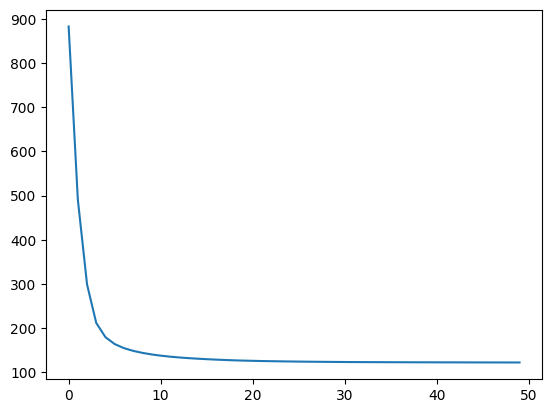

In [115]:
plt.plot(model.score_tracker['PerplexityScore'].value)

In [116]:
model.get_score('SparsityPhiScore')

value: 0.9505599737167358
zero_tokens: 95056
total_tokens: 100000

In [117]:
for topic_name in model.topic_names:
    print(topic_name + ': ',)
    print(model.score_tracker['Top10TokensScore'].last_tokens[topic_name])

topic_0: 
['состояние', 'продавать', 'отличный', 'обращаться', 'полностью', 'рабочий', 'игрушка', 'позволять', 'свежий', 'вести']
topic_1: 
['ходить', 'договор', 'отдаваться', 'судьба', 'старый', 'ненавязчивый', 'отслеживание', 'год', 'ответственный', 'добрый']
topic_2: 
['свой', 'начинать', 'делать', 'достигать', 'давно', 'успех', 'добро', 'благодаря', 'чувствовать', 'правильный']
topic_3: 
['принимать', 'страна', 'участие', 'российский', 'организация', 'решение', 'представитель', 'бизнес', 'совет', 'банк']
topic_4: 
['мастер', 'класс', 'вечер', 'творческий', 'студия', 'открытый', 'воскресение', 'покрытие', 'танец', 'приглашать']
topic_5: 
['билет', 'искусство', 'музыка', 'концерт', 'живой', 'художник', 'сказка', 'музыкальный', 'артист', 'спектакль']
topic_6: 
['вопрос', 'отвечать', 'сезон', 'мск', 'считать', 'изменение', 'заявлять', 'число', 'текст', 'президент']
topic_7: 
['конкурс', 'акция', 'праздник', 'русский', 'участник', 'начинаться', 'культура', 'весенний', 'проспект', 'побед

In [118]:
df['topic'] = model.transform(bv).idxmax(axis=0).str.replace('topic_', '').sort_index().astype(int)

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [119]:
df.head()

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


,ID,URL,CreatedDate,AuthorID,OwnerID,PostType,CommentCount,LikeCount,ShareCount,ViewsCount,...,LOC,PER,hashtags,link,text_clean,tokenized,stopwords_removed,snowball_stemmer,lemmatize_word_wo_pos,topic
0,VK_-58280124_133258,https://vk.com/wall-58280124_133258,2023-03-20T11:29:35Z,VK_-58280124,VK_-58280124,1,0,0,0,557,...,[Италия],[Туфли],[],[],продам туфли лак бренд италия родные н...,"[продам, туфли, лак, бренд, италия, родные, на...","[продам, туфли, лак, бренд, италия, родные, на...",прод туфл лак бренд итал родн набойк родн каче...,продавать туфля лак бренд италия родной набойк...,76.0
1,VK_-27_41164,https://vk.com/wall-27_41164,2023-03-12T02:11:00Z,VK_-27,VK_-27,1,0,165,8,5393,...,[Норильск],[Леонид Прядко],[],[],норильск с необычного ракурса фото леонид пр...,"[норильск, с, необычного, ракурса, фото, леони...","[норильск, необычного, ракурса, фото, леонид, ...",норильск необычн ракурс фот леонид прядк,норильск необычный ракурс фото леонид прядко,90.0
2,VK_-29148589_16516,https://vk.com/wall-29148589_16516,2023-03-20T09:22:07Z,VK_-29148589,VK_-29148589,1,0,12,0,941,...,NaN,"[Валерия Мартынова, ДневникКиношколы]",[#ДневникКиношколы],[],выставка студенческих работ в высшей школе реж...,"[выставка, студенческих, работ, в, высшей, шко...","[выставка, студенческих, работ, высшей, школе,...",выставк студенческ работ высш школ режиссер сц...,выставка студенческий работа высокий школа реж...,9.0
3,VK_-93005764_45620,https://vk.com/wall-93005764_45620,2023-03-15T09:10:04Z,VK_-93005764,VK_-93005764,1,3,6,0,522,...,"[Воронежской области, Воронеже, Артамонова, Со...","[Вячеслав Бочаров, Ивана Артамонова, Орлом, Ив...",[],[],вячеслав бочаров призвал власти воронежской об...,"[вячеслав, бочаров, призвал, власти, воронежск...","[вячеслав, бочаров, призвал, власти, воронежск...",вячесла бочар призва власт воронежск област ис...,вячеслав бочаров призывать власть воронежский ...,36.0
4,VK_-139507580_5438,https://vk.com/wall-139507580_5438,2023-03-03T13:30:00Z,VK_-139507580,VK_-139507580,1,0,2,0,145,...,[Домодедовская],"[Микрорайон, Павлом Железновым, Иваном Поздняк...",[],[https://www.novostroy-m.ru/kompanii/mr_group/...,скидка на весь пул квартир в жк эко видн...,"[скидка, на, весь, пул, квартир, в, жк, эко, в...","[скидка, весь, пул, квартир, жк, эко, видное, ...",скидк ве пул квартир жк эк видн запуст специал...,скидка весь пул квартира жк эко видный запуска...,48.0


In [ ]:
# for topic_name in model.topic_names:
#     print(topic_name)
#     top_tokens = set(model.score_tracker['Top100TokensScore'].last_tokens[topic_name])
#     frequencies = Counter()
#     for text in news_df[news_df.topic == int(topic_name.replace('topic_', ''))].text:
#         frequencies.update([token for token in tokenize(text) if token in top_tokens])

#     wordcloud = WordCloud(max_font_size=50, max_words=100, background_color="white").generate_from_frequencies(frequencies)
#     plt.figure(figsize=(10, 5))
#     plt.imshow(wordcloud, interpolation="bilinear")
#     plt.axis("off")
#     plt.show()

# Top2Vec

In [ ]:
!pip install top2vec

In [ ]:
from top2vec import Top2Vec
from sklearn.feature_extraction.text import TfidfVectorizer
from sentence_transformers import SentenceTransformer
from nltk.tokenize import word_tokenize


data = df[df["positive"] > 0.2]['stopwords_removed'].apply(lambda x: " ".join(x)).values.tolist()



# Предварительная обработка текстовых данных (например, токенизация)
def tokenizer(text):
    return word_tokenize(text, language="russian")


# Инициализация и обучение модели Top2Vec
topic_model = Top2Vec(
    data,
    embedding_model="universal-sentence-encoder-multilingual",
    speed="deep-learn",
    tokenizer=tokenizer,
    keep_documents=True,  # сохранение оригинальных текстов для дальнейшего использования
)
# Получение топ-тем и их ключевых слов
topics, word_scores, topic_nums = topic_model.get_topics()

# Вывод топ-тем и их ключевых слов
for topic in topics:
    print("Topic:", topic)
    for word in topics[topic]:
        print("-", word)

# Получение наиболее похожих документов для данной темы
topic_num = 0  # Номер темы, для которой нужно найти похожие документы
similar_documents, similarity = topic_model.search_documents_by_topic(topic_num, num_docs=5)

# Вывод наиболее похожих документов
print("Similar documents for topic", topic_num)
for doc, sim in zip(similar_documents, similarity):
    print("-", doc, "Similarity:", sim)


In [ ]:
topic_model.get_num_topics() #3
topic_words, word_scores, topic_nums = topic_model.get_topics(3)

for topic in topic_nums:
    topic_model.generate_topic_wordcloud(topic)

# LDA

In [64]:
from gensim import corpora, models

# Предобработка текста
documents = df['lemmatize_word_wo_pos'].values
texts = [[word for word in document.split()] for document in documents]

# Создание словаря
dictionary = corpora.Dictionary(texts)

# Преобразование документов в векторы
corpus = [dictionary.doc2bow(text) for text in texts]

# Обучение модели LDA
lda_model = models.LdaModel(corpus, num_topics=10, id2word=dictionary, passes=10)

# Вывод результатов
topics = lda_model.print_topics(num_words=10)
for topic in topics:
    print(topic)

/usr/local/lib/python3.10/dist-packages/google/rpc/__init__.py:20: DeprecationWarning: Deprecated call to `pkg_resources.declare_namespace('google.rpc')`.
Implementing implicit namespace packages (as specified in PEP 420) is preferred to `pkg_resources.declare_namespace`. See https://setuptools.pypa.io/en/latest/references/keywords.html#keyword-namespace-packages
  pkg_resources.declare_namespace(__name__)
/usr/local/lib/python3.10/dist-packages/pkg_resources/__init__.py:2349: DeprecationWarning: Deprecated call to `pkg_resources.declare_namespace('google')`.
Implementing implicit namespace packages (as specified in PEP 420) is preferred to `pkg_resources.declare_namespace`. See https://setuptools.pypa.io/en/latest/references/keywords.html#keyword-namespace-packages
  declare_namespace(parent)


(0, '0.018*"р" + 0.009*"размер" + 0.007*"руб" + 0.006*"новый" + 0.004*"работа" + 0.004*"москва" + 0.004*"состояние" + 0.004*"цена" + 0.004*"который" + 0.003*"лс"')
(1, '0.011*"год" + 0.010*"день" + 0.006*"который" + 0.005*"работа" + 0.004*"наш" + 0.004*"новый" + 0.003*"свой" + 0.003*"также" + 0.003*"это" + 0.003*"первый"')
(2, '0.005*"м" + 0.005*"который" + 0.004*"год" + 0.004*"дом" + 0.003*"р" + 0.003*"д" + 0.003*"хороший" + 0.003*"день" + 0.003*"руб" + 0.003*"квартира"')
(3, '0.010*"год" + 0.007*"свой" + 0.005*"который" + 0.004*"это" + 0.004*"человек" + 0.004*"место" + 0.004*"очень" + 0.003*"дом" + 0.003*"ссылка" + 0.003*"ребенок"')
(4, '0.010*"очень" + 0.007*"год" + 0.007*"дом" + 0.007*"человек" + 0.007*"кошка" + 0.006*"москва" + 0.006*"это" + 0.005*"искать" + 0.004*"ласковый" + 0.004*"свой"')
(5, '0.006*"март" + 0.006*"год" + 0.005*"москва" + 0.005*"который" + 0.004*"день" + 0.004*"новый" + 0.004*"россия" + 0.004*"это" + 0.003*"очень" + 0.003*"помогать"')
(6, '0.004*"работа" + 0.00